### Problem Statement: 
A Telecom company wants to predict their churn rate with high accuracy based on the historical data and consumer behavior so that they can prevent the customers long before they wish to actually leave the services provided by the company    

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

In [2]:
df = pd.read_csv("telco.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
df['InternetService'].unique()

array(['DSL', 'Fiber optic', 'No'], dtype=object)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
df.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

In [6]:
### Handling Missing values

df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [7]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [8]:
## Converting the binary values (categorical) of "Yes" and "No" into 1 and 0
list1 = ["gender", "SeniorCitizen", "Partner", "Dependents", "PhoneService", "PaperlessBilling", "Churn"]

In [9]:
## Looping through each element of a list
for i in list1:
    df[i] = df[i].map(lambda x: 0 if x== "Yes" else 1)

In [10]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [11]:
### Replacing all the whitespaces in all the columns with underscore.
### This is done so that we can draw a clear picture of XGBoost Trees
df.replace(" ", "_", regex=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   int64  
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   int64  
 4   Dependents        7043 non-null   int64  
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   int64  
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   int64  


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   int64  
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   int64  
 4   Dependents        7043 non-null   int64  
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   int64  
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   int64  


In [13]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,1,1,0,1,1,1,No_phone_service,DSL,No,...,No,No,No,No,Month-to-month,0,Electronic_check,29.85,29.85,1
1,5575-GNVDE,1,1,1,1,34,0,No,DSL,Yes,...,Yes,No,No,No,One_year,1,Mailed_check,56.95,1889.5,1
2,3668-QPYBK,1,1,1,1,2,0,No,DSL,Yes,...,No,No,No,No,Month-to-month,0,Mailed_check,53.85,108.15,0
3,7795-CFOCW,1,1,1,1,45,1,No_phone_service,DSL,Yes,...,Yes,Yes,No,No,One_year,1,Bank_transfer_(automatic),42.30,1840.75,1
4,9237-HQITU,1,1,1,1,2,0,No,Fiber_optic,No,...,No,No,No,No,Month-to-month,0,Electronic_check,70.70,151.65,0


In [14]:
df.drop(["customerID"], axis= 1, inplace=True)


In [15]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1,1,0,1,1,1,No_phone_service,DSL,No,Yes,No,No,No,No,Month-to-month,0,Electronic_check,29.85,29.85,1
1,1,1,1,1,34,0,No,DSL,Yes,No,Yes,No,No,No,One_year,1,Mailed_check,56.95,1889.5,1
2,1,1,1,1,2,0,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,0,Mailed_check,53.85,108.15,0
3,1,1,1,1,45,1,No_phone_service,DSL,Yes,No,Yes,Yes,No,No,One_year,1,Bank_transfer_(automatic),42.30,1840.75,1
4,1,1,1,1,2,0,No,Fiber_optic,No,No,No,No,No,No,Month-to-month,0,Electronic_check,70.70,151.65,0


In [16]:
### Converting the object datatype into float type

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])

ValueError: Unable to parse string "_" at position 488

We can see that we are not able to convert the string datatype into numerical due to the fact given in the above <b>"ValueError"</b>: Unable to parse string "_" at position 488


In [17]:
## Let's see where the problem is by using loc operator

df.loc[df['TotalCharges']=='_']

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,1,1,0,0,0,1,No_phone_service,DSL,Yes,No,Yes,Yes,Yes,No,Two_year,0,Bank_transfer_(automatic),52.55,_,1
753,1,1,1,0,0,0,No,No,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,Two_year,1,Mailed_check,20.25,_,1
936,1,1,0,0,0,0,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two_year,1,Mailed_check,80.85,_,1
1082,1,1,0,0,0,0,Yes,No,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,Two_year,1,Mailed_check,25.75,_,1
1340,1,1,0,0,0,1,No_phone_service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two_year,1,Credit_card_(automatic),56.05,_,1
3331,1,1,0,0,0,0,No,No,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,Two_year,1,Mailed_check,19.85,_,1
3826,1,1,0,0,0,0,Yes,No,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,Two_year,1,Mailed_check,25.35,_,1
4380,1,1,0,0,0,0,No,No,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,Two_year,1,Mailed_check,20.00,_,1
5218,1,1,0,0,0,0,No,No,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,One_year,0,Mailed_check,19.70,_,1
6670,1,1,0,0,0,0,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two_year,1,Mailed_check,73.35,_,1


### Comment:
We can clearly see that in those rows where the total charges is missing, the values in tenure is mentioned as 0. Either it is an human error or the customer has just joined the telco company. Hence, we can set them to 0

In [18]:
df.loc[(df['TotalCharges'] == '_'), 'TotalCharges'] = 0

In [19]:
### Converting the object datatype into float type

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])

In [20]:
### Splitting data into dependent and independent variable

X = df.drop("Churn", axis = 1).copy()
y = df["Churn"].copy()

In [21]:
X.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,1,1,0,1,1,1,No_phone_service,DSL,No,Yes,No,No,No,No,Month-to-month,0,Electronic_check,29.85,29.85
1,1,1,1,1,34,0,No,DSL,Yes,No,Yes,No,No,No,One_year,1,Mailed_check,56.95,1889.50
2,1,1,1,1,2,0,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,0,Mailed_check,53.85,108.15
3,1,1,1,1,45,1,No_phone_service,DSL,Yes,No,Yes,Yes,No,No,One_year,1,Bank_transfer_(automatic),42.30,1840.75
4,1,1,1,1,2,0,No,Fiber_optic,No,No,No,No,No,No,Month-to-month,0,Electronic_check,70.70,151.65


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   int64  
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   int64  
 3   Dependents        7043 non-null   int64  
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   int64  
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   int64  
 16  PaymentMethod     7043 non-null   object 


In [23]:
### Converting the remaining categorical values into numerical data using one-hot encoding

list2 = ["MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "PaymentMethod" ,"StreamingTV", "StreamingMovies", "Contract"]

In [24]:
X_encoded = pd.get_dummies(data = X, columns = list2, drop_first = True)
X_encoded.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,MultipleLines_No_phone_service,...,TechSupport_Yes,PaymentMethod_Credit_card_(automatic),PaymentMethod_Electronic_check,PaymentMethod_Mailed_check,StreamingTV_No_internet_service,StreamingTV_Yes,StreamingMovies_No_internet_service,StreamingMovies_Yes,Contract_One_year,Contract_Two_year
0,1,1,0,1,1,1,0,29.85,29.85,1,...,0,0,1,0,0,0,0,0,0,0
1,1,1,1,1,34,0,1,56.95,1889.50,0,...,0,0,0,1,0,0,0,0,1,0
2,1,1,1,1,2,0,0,53.85,108.15,0,...,0,0,0,1,0,0,0,0,0,0
3,1,1,1,1,45,1,1,42.30,1840.75,1,...,1,0,0,0,0,0,0,0,1,0
4,1,1,1,1,2,0,0,70.70,151.65,0,...,0,0,1,0,0,0,0,0,0,0


In [25]:
## Let's observe how class = 1 and class = 0 are distributed for churn column
sum(y)/len(y)

0.7346301292063041

We can see that <b>73.4%</b> people have left the telecom company and because of which, when we split the data into training and testing, we will split using stratification in order to maintain the same percentage of people who left the company in both training and testing set

In [26]:
### Train-Test Split

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42, stratify = y, test_size = 0.2)

### Building the baseline model for XGBoost Model

In order to create a base model, we will use the XGBoost parameter called early stopping rounds to stop building trees when they no longer improve the situation.

In [27]:
clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic', missing = 1, seed = 42)

clf_xgb.fit(X_train, 
            y_train,
            verbose = True,
            early_stopping_rounds = 10,
            eval_metric = 'aucpr',
            eval_set = [(X_test, y_test)])

[0]	validation_0-aucpr:0.92127
[1]	validation_0-aucpr:0.92852
[2]	validation_0-aucpr:0.92919
[3]	validation_0-aucpr:0.92997
[4]	validation_0-aucpr:0.93004
[5]	validation_0-aucpr:0.93020
[6]	validation_0-aucpr:0.92997
[7]	validation_0-aucpr:0.92983
[8]	validation_0-aucpr:0.92952
[9]	validation_0-aucpr:0.92996
[10]	validation_0-aucpr:0.92903
[11]	validation_0-aucpr:0.92905
[12]	validation_0-aucpr:0.92626
[13]	validation_0-aucpr:0.92537
[14]	validation_0-aucpr:0.92729
[15]	validation_0-aucpr:0.92819


C:\Users\tuhin\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=1, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

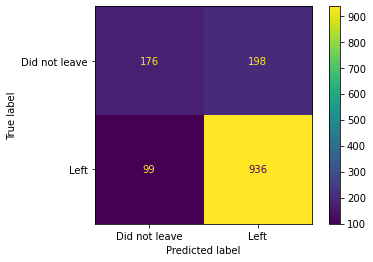

In [28]:
## Let's visualize how the test data performed as per confusion matrix

plot_confusion_matrix(clf_xgb,
                     X_test,
                     y_test,
                     values_format = 'd',
                     display_labels = ['Did not leave', 'Left'])

### Inferences from the baseline model

- We can see that 936 people (90.4%) of the clients who left the company are correctly predicted out of 1035 people.

- We can see that 176 people (47.0%) of the clients who did not leave the company are correctly predicted out of 374 people


#### This baseline model will help solve the problem of predicting customer churn, which is our problem statement with correct prediction rate of 90.4%. 
#### Let's see if we can optimize this model and make it better than baseline model

### Optimize parameters using Cross Validation and Grid Search CV

In [29]:
## Model 1

param_grids = { 'max_depth': [3, 4, 5],
               'learning_rate': [0.1, 0.01, 0.05],
               'gamma': [0, 0.25, 1.0],
               'reg_lambda': [0, 1.0, 10.0],
               'scale_pos_weight': [1, 3, 5]
}

In [32]:
optimal_params_1 = GridSearchCV(estimator = xgb.XGBClassifier(objective = 'binary:logistic',
                                                             seed = 42,
                                                             subsample = 0.9,
                                                             colsample_bytree = 0.5),
                                param_grid = param_grids,
                                scoring = 'roc_auc',
                                verbose = 2,
                                n_jobs = -1,
                                cv = 4)

In [33]:
optimal_params_1.fit(X_train, 
            y_train,
            verbose = False,
            early_stopping_rounds = 10,
            eval_metric = 'auc',
            eval_set = [(X_test, y_test)])

print(optimal_params_1.best_params_)

Fitting 4 folds for each of 243 candidates, totalling 972 fits


C:\Users\tuhin\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


{'gamma': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 10.0, 'scale_pos_weight': 3}


In [ ]:
### Building, evaluating and interpreting the optimal XGBoost Model

In [34]:
clf_xgb = xgb.XGBClassifier(seed = 42,
                           objective = 'binary:logistic',
                           gamma = 1.0,
                           learning_rate = 0.1,
                           max_depth = 5,
                           reg_lambda = 10.0,
                           scale_pos_weight = 3,
                           subsample = 0.9,
                           colsample_bytree = 0.5)

clf_xgb.fit(X_train,
           y_train,
           verbose=True,
           early_stopping_rounds=10,
           eval_metric='aucpr',
           eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.85591
[1]	validation_0-aucpr:0.89701
[2]	validation_0-aucpr:0.91701
[3]	validation_0-aucpr:0.92024
[4]	validation_0-aucpr:0.91958
[5]	validation_0-aucpr:0.91998
[6]	validation_0-aucpr:0.92060
[7]	validation_0-aucpr:0.91988
[8]	validation_0-aucpr:0.92269
[9]	validation_0-aucpr:0.92275
[10]	validation_0-aucpr:0.92403
[11]	validation_0-aucpr:0.92733
[12]	validation_0-aucpr:0.92696
[13]	validation_0-aucpr:0.92875
[14]	validation_0-aucpr:0.92876
[15]	validation_0-aucpr:0.92871
[16]	validation_0-aucpr:0.92944
[17]	validation_0-aucpr:0.92893
[18]	validation_0-aucpr:0.92939
[19]	validation_0-aucpr:0.92991
[20]	validation_0-aucpr:0.93016
[21]	validation_0-aucpr:0.93032
[22]	validation_0-aucpr:0.93135
[23]	validation_0-aucpr:0.93164
[24]	validation_0-aucpr:0.93138
[25]	validation_0-aucpr:0.93125
[26]	validation_0-aucpr:0.93134
[27]	validation_0-aucpr:0.93173
[28]	validation_0-aucpr:0.93152
[29]	validation_0-aucpr:0.93192
[30]	validation_0-aucpr:0.93196
[31]	validation_0-

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=1.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=10.0, scale_pos_weight=3, seed=42,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

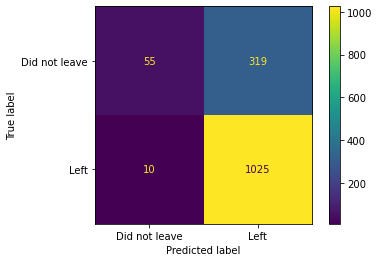

In [35]:
## Let's visualize how the test data performed as per confusion matrix

plot_confusion_matrix(clf_xgb,
                     X_test,
                     y_test,
                     values_format = 'd',
                     display_labels = ['Did not leave', 'Left'])

### Inferences from the optimized model
We can see that 1025 people (99.0 %) of the people who left the company are correctly predicted out of 1035 people.

We can see that 176 people (14.7 %) of the clients who did not leave the company are correctly predicted out of 374 people
